# Convolutional Autoencoder for CIFAR10

Samantha Sánchez Tinoco


-------------------------------------------------

An autoencoder is a type of neural network that learns to compress data and then reconstruct it.  

It has two main parts:

- **Encoder** → compresses the input into a smaller representation (latent space)
- **Decoder** → reconstructs the image from that compressed representation

In this assignment, we use CIFAR10 images (32x32 RGB) and create 3 levels of compression:

Original → h1 → h2 → h3 → z

The goal is to reduce the spatial dimensions while increasing feature depth.

In [4]:
# Import libraries

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## CIFAR10 Dataset

CIFAR10 contains 60,000 RGB images of size 32x32.

We need to convert the images to tensors and load them using a DataLoader.


In [5]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert images to tensor
transform = transforms.ToTensor()

# Download dataset
trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

print("Dataset loaded successfully")

100.0%
c:\Users\samys\miniconda3\envs\DeepLearning\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Dataset loaded successfully


## Convolutional Autoencoder

The encoder reduces the image size step by step:
- 32x32 → 16x16
- 16x16 → 8x8
- 8x8 → 4x4

Them the decoder reconstructs the image back to 32x32.

In [6]:
# Encoder
encoder = nn.Sequential(
    # First compression level
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # 32x32 → 16x16
    nn.ReLU(),

    # Second compression level
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 16x16 → 8x8
    nn.ReLU(),

    # Third compression level
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 8x8 → 4x4
    nn.ReLU()
)

In [8]:
# Decoder
decoder = nn.Sequential(
    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),

    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),

    nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.Sigmoid()  # Output between 0 and 1
)

encoder = encoder.to(device)
decoder = decoder.to(device)

## Loss Function and Optimizer

For this assignment we will use:

- **MSELoss** because we are reconstructing images.
- **Adam optimizer** because it works well.


In [9]:
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=0.001
)

## Train the Autoencoder

The model learns by minimizing the reconstruction error between:
- Original image
- Reconstructed image

In [ ]:
for epoch in range(10):
    total_loss = 0

    for images, _ in trainloader:
        images = images.to(device)

        # Encoder and decoder
        encoded = encoder(images)
        reconstructed = decoder(encoded)

        # Calculate loss
        loss = criterion(reconstructed, images)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(trainloader):.4f}")


Epoch 1, Loss: 0.0211
Epoch 2, Loss: 0.0089
Epoch 3, Loss: 0.0066
Epoch 4, Loss: 0.0055
Epoch 5, Loss: 0.0049
Epoch 6, Loss: 0.0046
Epoch 7, Loss: 0.0043
Epoch 8, Loss: 0.0042
Epoch 9, Loss: 0.0040
Epoch 10, Loss: 0.0040


## Visualizing Reconstructions

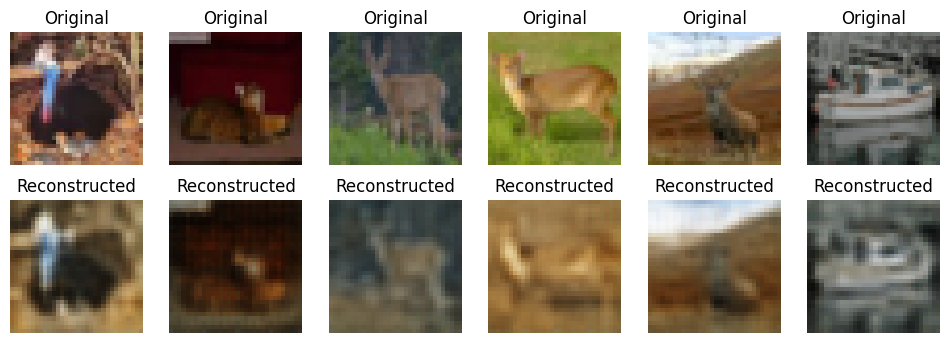

In [13]:
# Get a batch of images
images, _ = next(iter(trainloader))
images = images.to(device)

# Reconstruct
encoded = encoder(images)
reconstructed = decoder(encoded)

# Move to CPU for plotting
images = images.cpu().detach()
reconstructed = reconstructed.cpu().detach()

# Plot original vs reconstructed
fig, axes = plt.subplots(2, 6, figsize=(12,4))

for i in range(6):
    axes[0,i].imshow(images[i].permute(1,2,0))
    axes[0,i].set_title("Original")
    axes[0,i].axis("off")

    axes[1,i].imshow(reconstructed[i].permute(1,2,0))
    axes[1,i].set_title("Reconstructed")
    axes[1,i].axis("off")

plt.show()


## Conclusion

The encoder made for this assignment compresses the image through three convolutional layers,
reducing spatial dimensions while increasing feature depth.

Then decoder reconstructs the image using transpose convolutions.

The model learns by minimizing the reconstruction error (MSE).

This type of model can be used for:
- Image compression
- Denoising
- Feature extraction
- Dimensionality reduction

The results show that even after compression, the model can reconstruct images that are visually similar to the originals.